In [3]:
"""
Generating the experts.
"""
# ----------------------------------------------------------------------------------------------------------------------
# imports
import sys
import pickle
import numpy as np
sys.path.append('/Users/tingtingni/Documents/code/')
from env.gridworld import Gridworld
from algs.cmdp import cmdp_gda, cmdp_gda_occ, regularization
from examples.log_barrier import *
import visualization.gridworld_vis as gv
from einops import rearrange, reduce, repeat, einsum
import copy

import random
import pandas as pd
import argparse
from pathlib import Path
from scipy.stats import entropy


float_formatter = "{:.8f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

# ----------------------------------------------------------------------------------------------------------------------
# Parse command line arguments
# default values
b_str = 'low'
noise = 0.1
N = 10000
seed = 20

data_path = 'data/expert_data/'+str(noise)+'_noise/'+b_str+'_b/'
Path(data_path).mkdir(parents=True, exist_ok=True)
plotting = True

# ----------------------------------------------------------------------------------------------------------------------
# Fix random seeds for reproducibility
random.seed(seed)
np.random.seed(seed)

# ----------------------------------------------------------------------------------------------------------------------
# create environment
params = {
    'grid_height': 6,
    'grid_width' : 6,
    'noise': float(noise),
    'gamma': 0.7
}
n = params['grid_height'] * params['grid_width']
m = 4 # number of actions
k = 2 # number of constaints
Psi = np.zeros((params['grid_height'], params['grid_width'], m, k))
Psi[1:5, 1, :, 0] = 10
Psi[1:5, 3, :, 1] = 10
# Psi[2:5, 3, :, 2] = 1 ,[[2,3],[3,1]]
Psi = rearrange(Psi, 'sx sy a k -> (sy sx) a k')
constraint_patches = np.array([[[1,1],[4,1]], [[1,3],[4,1]]])
b = np.array([1.8, 1.8])
nu0 = np.ones(n) / (n - len(np.nonzero(Psi[:,0,:])[0]))
nu0[np.nonzero(Psi[:,0,:])[0]] = 0.0
r = np.zeros((n, m))
r[15,:] = 1
env = Gridworld(**params, constraints = (Psi, b), nu0 =  nu0, r = r)
env.P[15, :, :] = np.zeros_like(env.P[0, :, :])
env.P[15, :, 15] = 1.0
beta = 1.0

print('params', params)
print('N', N)
print('noise', noise)
print('seed', seed)

# Approximate solution to regularized problem
eta_p = (1-env.gamma) /beta * 1
eta_xi = 0.1
print('-----------')
print('GDA solution')
policy_soft, xi, values_soft = cmdp_gda(env, beta , eta_p, eta_xi, max_iters=1e4, tol=-1, mode='alt_gda',
                                    n_v_tot_eval_steps=50, n_v_c_eval_steps=50, logging=True, check_steps=1000)
occ_soft = env.policy2stateactionocc(policy_soft)

print('objective: ', np.sum(occ_soft * env.r / (1-env.gamma)))
print('constraints: ', np.einsum('jki,jk->i', env.Psi, occ_soft) / (1-env.gamma))
print('primal: ', np.sum(occ_soft * env.r / (1-env.gamma)) - regularization(env, occ_soft, beta))
print('dual value: ', np.sum(occ_soft * env.r / (1-env.gamma)) - regularization(env, occ_soft, beta) + np.sum(xi * (env.b - np.einsum('jki,jk->i', env.Psi, occ_soft) / (1-env.gamma))))

# set up the env
b = np.array([2, 2])
env = Gridworld(**params, constraints = (Psi, b), nu0 =  nu0, r = r)
env.P[15, :, :] = np.zeros_like(env.P[0, :, :])
env.P[15, :, 15] = 1.0

# ----------------------------------------------------------------------------------------------------------------------
# Get expert
# LP solution (as sanity check)
print('-----------')
print('LP solution')
occ_lp, sol = env.lp_solve()
print(sol.message)
print('objective: ', -sol.fun)
policy_lp = env.occ2policy(occ_lp)
print('constraints: ', np.einsum('jki,jk->i', env.Psi, occ_lp) / (1-env.gamma))

construct transition matrix
transition matrix constructed
params {'grid_height': 6, 'grid_width': 6, 'noise': 0.1, 'gamma': 0.7}
N 10000
noise 0.1
seed 20
-----------
GDA solution
step:  0 , primal:  4.85938 , dual:  [0.00000000 0.00000000] , constraint-viol:  0.00000
step:  1000 , primal:  4.96376 , dual:  [0.00000000 0.00171684] , constraint-viol:  0.00000
step:  2000 , primal:  4.96376 , dual:  [0.00000000 0.00171684] , constraint-viol:  0.00000
step:  3000 , primal:  4.96376 , dual:  [0.00000000 0.00171684] , constraint-viol:  0.00000
step:  4000 , primal:  4.96376 , dual:  [0.00000000 0.00171684] , constraint-viol:  0.00000
step:  5000 , primal:  4.96376 , dual:  [0.00000000 0.00171684] , constraint-viol:  0.00000
step:  6000 , primal:  4.96376 , dual:  [0.00000000 0.00171684] , constraint-viol:  0.00000
step:  7000 , primal:  4.96376 , dual:  [0.00000000 0.00171684] , constraint-viol:  0.00000
step:  8000 , primal:  4.96376 , dual:  [0.00000000 0.00171684] , constraint-viol:  0.0

In [4]:
import pickle
import os
It_n = 4000
batch = 10
mode_n =  4
reward = np.zeros((batch, mode_n, It_n))
cost = np.zeros((batch, mode_n, It_n, env.k))
safe = np.zeros((batch, mode_n))
theta = np.zeros((batch, mode_n, env.n * env.m))
# Open the pickle file in binary read mode
for i in range(batch):
    # Example loop
    for j in range(mode_n):
        file_path = f'data/{j}_{i}_reward.pkl'
        with open(file_path, 'rb') as file:
            # Load the data from the pickle file
            data = pickle.load(file)
            reward[i, j, :] = data
        file_path = f'data/{j}_{i}_cost.pkl'
        with open(file_path, 'rb') as file:
            # Load the data from the pickle file
            data = pickle.load(file)
            cost[i, j, :] = data
        file_path = f'data/{j}_{i}_theta.pkl'
        with open(file_path, 'rb') as file:
            # Load the data from the pickle file
            data = pickle.load(file)
            theta[i, j, :] = data
        file_path = f'data/{j}_{i}_safe.pkl'
        with open(file_path, 'rb') as file:
            # Load the data from the pickle file
            data = pickle.load(file)
            safe[i, j] = data
 



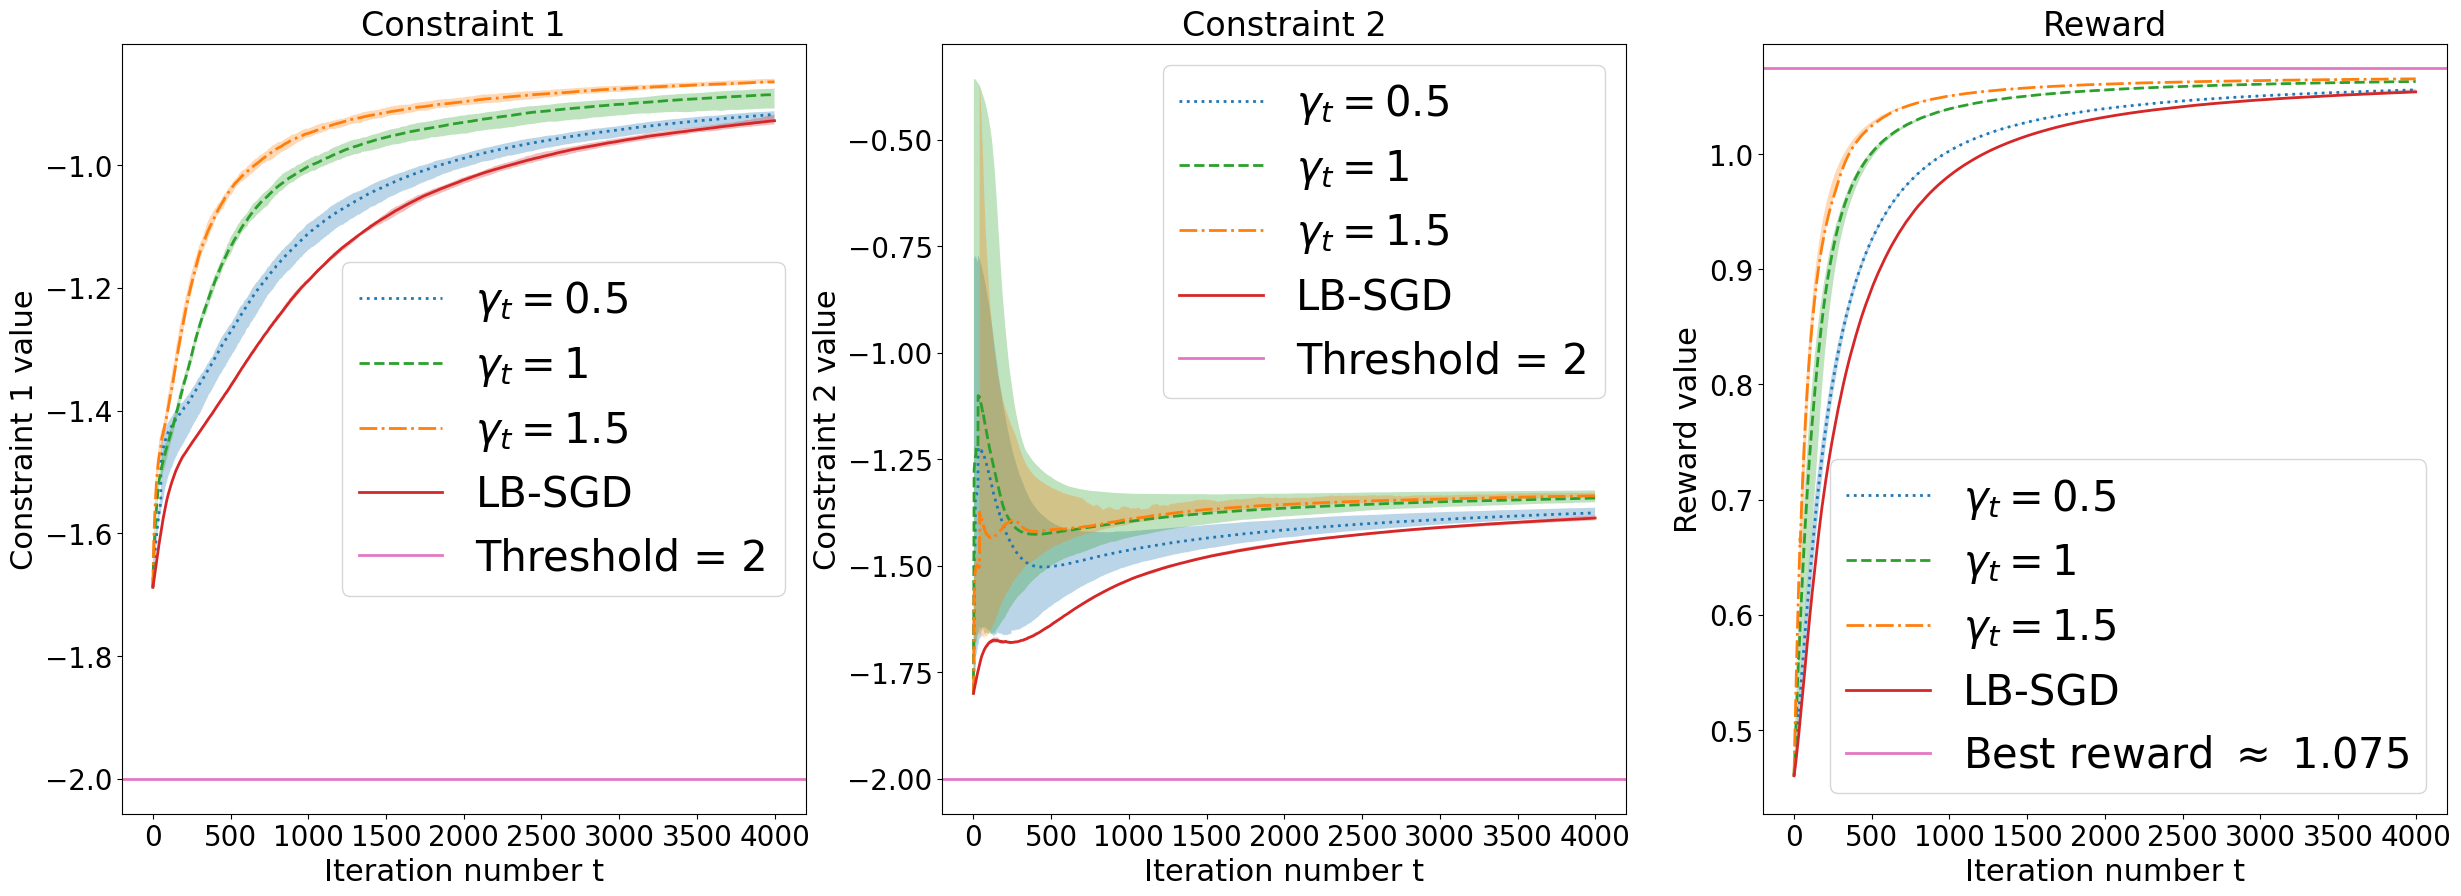

In [5]:
# Plot
re_avg = np.mean(reward, axis=0)
# re_max = np.max(reward, axis=0)
# re_min = np.min(reward, axis=0)
re_max = np.quantile(reward, 0.9, axis=0)
re_min = np.quantile(reward, 0.1, axis=0)

c_avg = -np.mean(cost, axis=0)
c_max = -np.quantile(cost, 0.9, axis=0)
c_min = -np.quantile(cost, 0.1, axis=0)
# c_max = np.max(cost, axis=0)
# c_min = np.min(cost, axis=0)
import matplotlib.pyplot as plt
import math
import matplotlib.gridspec as gridspec
colorlist = ['tab:blue','tab:green','tab:orange', 'tab:red','tab:purple', 'tab:gray','tab:brown', 'tab:pink']
mode_w = [r'$\gamma_t=0.5$',r'$\gamma_t=1$',r'$\gamma_t=1.5$', 'LB-SGD']
linestyle_str = ['dotted','dashed', 'dashdot','solid']  # Same as '-.'
# Create (2,2) sub plots
gs = gridspec.GridSpec(1, 3)
fig = plt.figure(figsize=(30,10))

ax = plt.subplot(gs[0, 0])
for i in range(mode_n): 
    ax.plot(range(np.size(c_avg[i, :, 0])), c_avg[i, :, 0], color = colorlist[i], linestyle = linestyle_str[i], label = mode_w[i], linewidth=2)
    plt.legend(loc = 'center right')
    ax.fill_between(range(np.size(c_avg[i, :, 0])), c_min[i, :, 0], c_max[i, :, 0], alpha = 0.3, facecolor = colorlist[i])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
ax.set_xlabel("Iteration number t", color = 'black', fontsize=22)
ax.set_ylabel("Constraint 1 value", color = 'black', fontsize=22)
ax.axhline(y =  -env.b[0], color = 'tab:pink',label = 'Threshold = 2', linewidth=2)
plt.legend(fontsize=24)
plt.legend(loc = 'center right', fontsize=30)
plt.title('Constraint 1', fontsize=24)

ax = plt.subplot(gs[0, 1]) 
for i in range(mode_n): 
    ax.plot(range(np.size(c_avg[i, :, 1])), c_avg[i, :, 1], color = colorlist[i], linestyle = linestyle_str[i], label = mode_w[i], linewidth=2)
    ax.fill_between(range(np.size(c_avg[i, :, 1])), c_min[i, :, 1], c_max[i, :, 1], alpha = 0.3, facecolor = colorlist[i])
    plt.legend(loc = 'lower right')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
ax.set_xlabel("Iteration number t", color = 'black', fontsize=22)
ax.set_ylabel("Constraint 2 value", color = 'black', fontsize=22)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.axhline(y =  -env.b[1], color = 'tab:pink',label = 'Threshold = 2', linewidth=2)
ax.legend(fontsize=24)
plt.legend(loc = 'upper right', fontsize=30)
plt.title('Constraint 2', fontsize=24)

ax = plt.subplot(gs[0, 2])
for i in range(mode_n): 
    ax.plot(range(np.size(re_avg[i, :])), re_avg[i, :], color = colorlist[i], linestyle = linestyle_str[i], label = mode_w[i], linewidth=2)
    ax.fill_between(range(np.size(re_avg[i, :])), re_min[i, :], re_max[i, :], alpha = 0.3, facecolor = colorlist[i])
    plt.legend(loc = 'lower right')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
ax.set_xlabel("Iteration number t", color = 'black', fontsize=22)
ax.set_ylabel("Reward value", color = 'black', fontsize=22)
ax.axhline(y = -sol.fun, color = 'tab:pink',label = r'Best reward $\approx$ 1.075', linewidth=2)
plt.legend(loc = 'lower right', fontsize=30)
plt.title('Reward', fontsize=24)



# fig.suptitle(r'$6\times 6$ gridworld with $\eta=10^{-2}$', fontsize = 'xx-large')
plt.show()
fig.savefig('lblearning.svg', format='svg', dpi=1200)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
# Define the width and height for individual figures
image_width = 380  # Adjust the width as needed
image_height = 300  # Adjust the height as needed

# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(image_width / 100, image_height / 100))  # Use the same size for all figures
# Generate and save the three figures to temporary image files
figure_paths = []
figure = gv.plot_gridworld(env, policy_lp,'Optimal', env.grid_width, env.grid_height, values = env.r[:,1], constraints = constraint_patches, logging = True)
figure_path = f"figure_lp_optimal.png"
figure.set_size_inches(image_width / 100, image_height / 100)  # Set figure size
figure.savefig(figure_path, format='png', dpi=300)
plt.close(figure)  # Close the figure to free memory